<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_CNN4_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.vgg19 import preprocess_input,VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.layers import Dense,Flatten,Dropout
from keras.regularizers import l2

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age group conversion
def age_to_range(age):
    return age // 5 # Convert ages to 5-year interval indices

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [7]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/part1'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    range_index = age_to_range(age)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, np.max(age_groups) + 1)

In [8]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (9931, 224, 224, 3)
Labels shape: (9931, 23)


In [9]:
def age_group_to_interval(group_index, interval=5):
    start = group_index * interval
    end = (group_index + 1) * interval - 1
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/part1/28_1_0_20...,25-29
1,/content/drive/MyDrive/Dataset/part1/35_0_0_20...,35-39
2,/content/drive/MyDrive/Dataset/part1/38_0_4_20...,35-39
3,/content/drive/MyDrive/Dataset/part1/50_1_0_20...,50-54
4,/content/drive/MyDrive/Dataset/part1/20_1_2_20...,20-24
5,/content/drive/MyDrive/Dataset/part1/35_0_4_20...,35-39
6,/content/drive/MyDrive/Dataset/part1/57_0_0_20...,55-59
7,/content/drive/MyDrive/Dataset/part1/51_0_0_20...,50-54
8,/content/drive/MyDrive/Dataset/part1/36_1_0_20...,35-39
9,/content/drive/MyDrive/Dataset/part1/39_0_0_20...,35-39


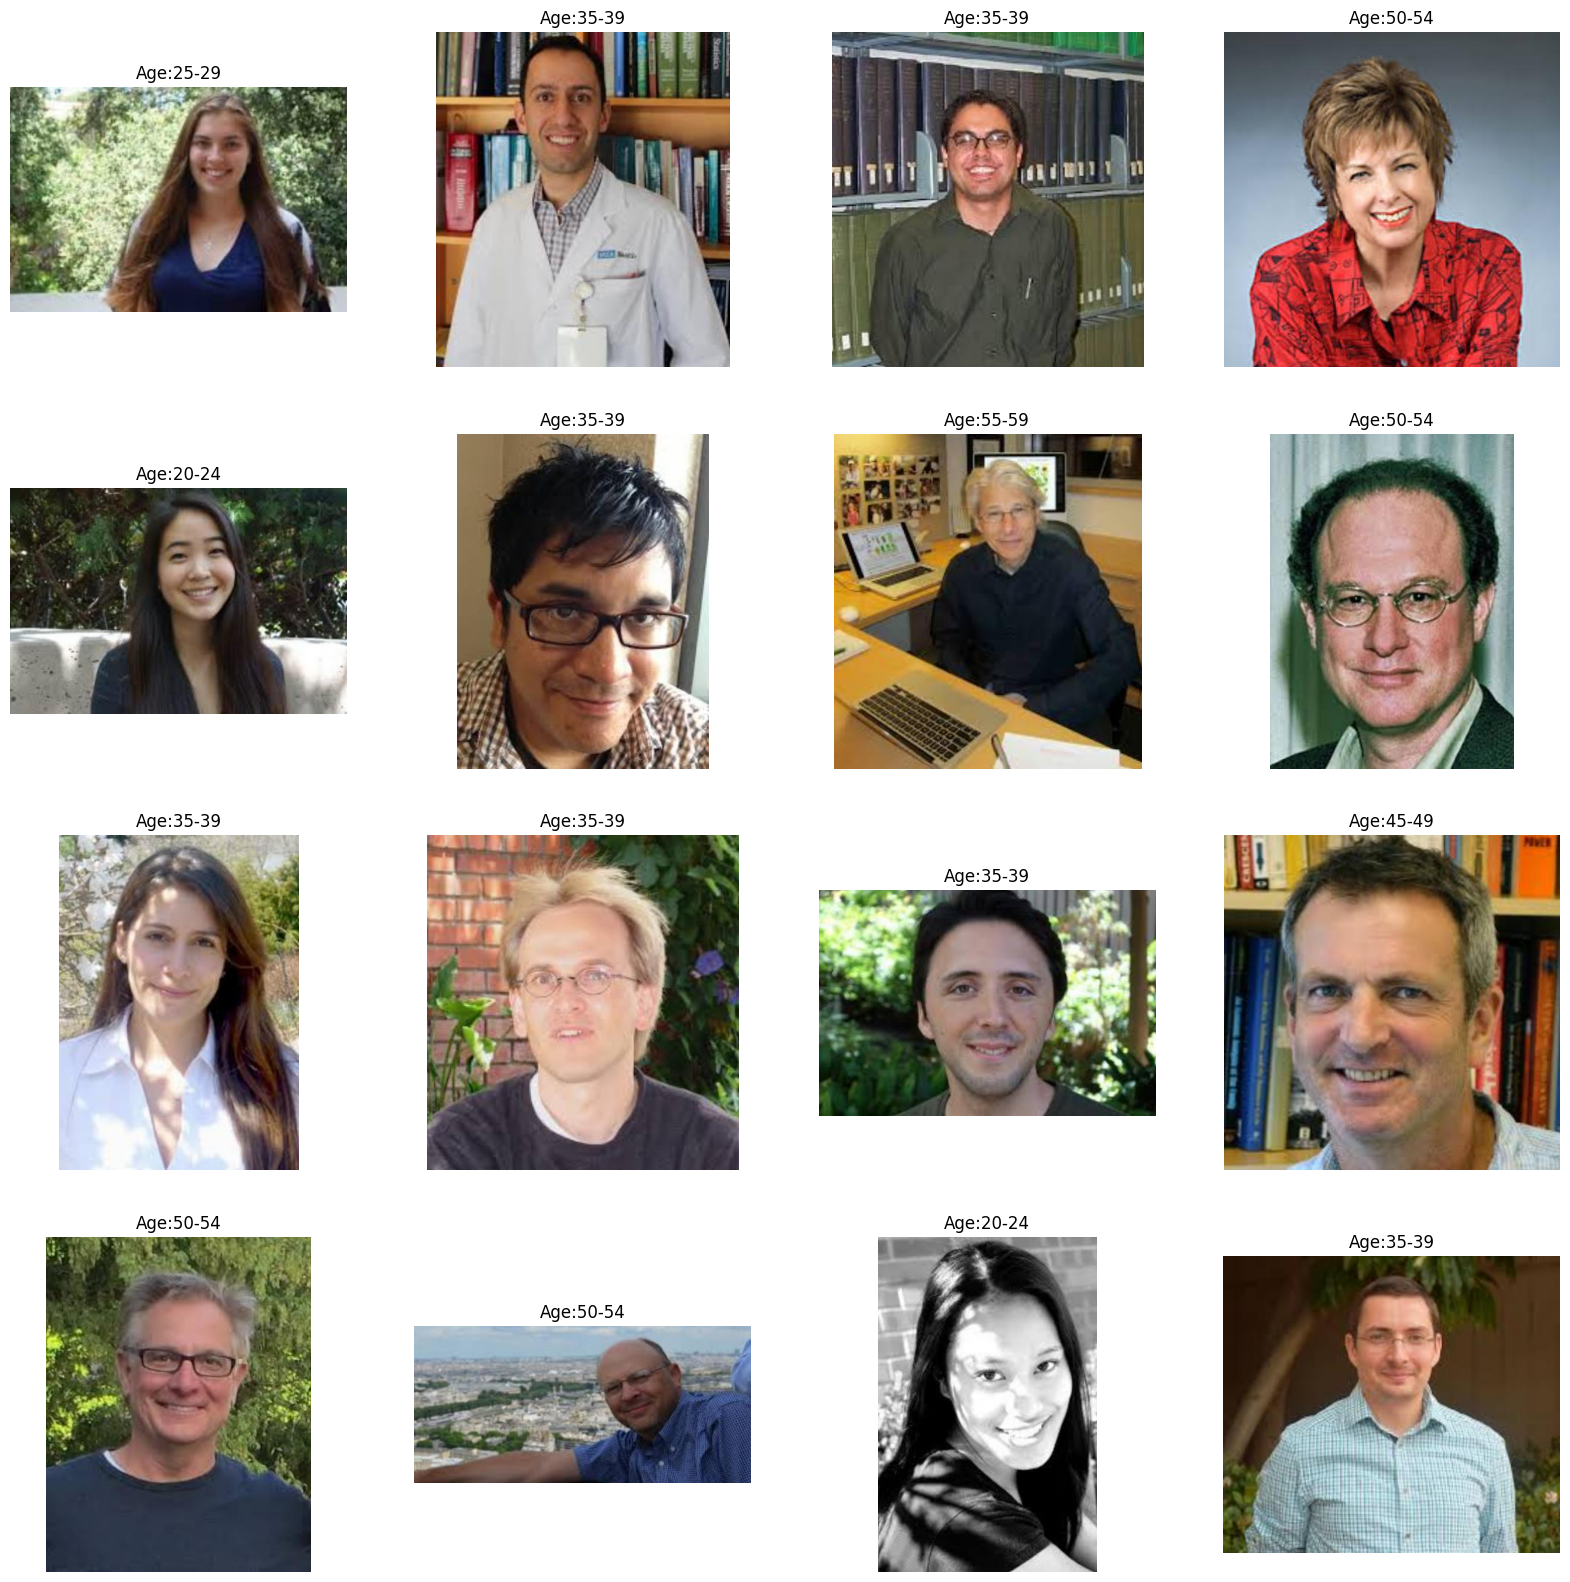

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

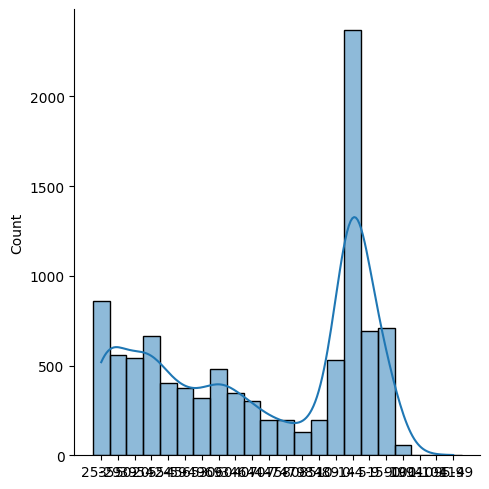

In [12]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [13]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [14]:
# Load the pre-trained ResNet50 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Prevent training already trained layers
for layer in base_model.layers:
  layer.trainable = False

# Add custom layers on top of the base model
#Add flatten layer
x = Flatten()(base_model.output)
#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(np.max(age_groups)+1, activation='softmax')(x)

#Create the model object
model = Model(inputs=base_model.input, outputs=prediction)

model.summary()


80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [16]:
# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics = ["accuracy"])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/D1_CNN4_A2.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [18]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[early_stopping, model_checkpoint],shuffle=False)


Epoch 1/60
199/199 [==============================] - ETA: 0s - loss: 10.4901 - accuracy: 0.1998
Epoch 1: val_accuracy improved from -inf to 0.30648, saving model to /content/drive/MyDrive/Dataset/D1_CNN4_A2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 46s 188ms/step - loss: 10.4901 - accuracy: 0.1998 - val_loss: 4.6698 - val_accuracy: 0.3065
Epoch 2/60
199/199 [==============================] - ETA: 0s - loss: 5.7446 - accuracy: 0.2820
Epoch 2: val_accuracy improved from 0.30648 to 0.31718, saving model to /content/drive/MyDrive/Dataset/D1_CNN4_A2.h5
199/199 [==============================] - 33s 167ms/step - loss: 5.7446 - accuracy: 0.2820 - val_loss: 4.5312 - val_accuracy: 0.3172
Epoch 3/60
199/199 [==============================] - ETA: 0s - loss: 4.8985 - accuracy: 0.3382
Epoch 3: val_accuracy improved from 0.31718 to 0.32662, saving model to /content/drive/MyDrive/Dataset/D1_CNN4_A2.h5
199/199 [==============================] - 34s 171ms/step - loss: 4.8985 - accuracy: 0.3382 - val_loss: 4.4476 - val_accuracy: 0.3266
Epoch 4/60
199/199 [==============================] - ETA: 0s - loss: 4.5912 - accuracy: 0.3756
Epoch 4: val_accuracy improved from 0.32662 to 0.33417, saving model to /co

In [19]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/D1_CNN4_A2.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


63/63 [==============================] - 8s 124ms/step - loss: 3.2874 - accuracy: 0.3885
Test Accuracy: 38.85%


In [20]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

63/63 [==============================] - 7s 111ms/step


In [21]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       485
           1       0.30      0.28      0.29       134
           2       0.29      0.19      0.23       105
           3       0.32      0.40      0.36       145
           4       0.32      0.42      0.37       146
           5       0.22      0.27      0.25       175
           6       0.06      0.06      0.06        90
           7       0.14      0.17      0.15       103
           8       0.00      0.00      0.00        64
           9       0.16      0.16      0.16        76
          10       0.23      0.17      0.19       120
          11       0.10      0.09      0.09        70
          12       0.17      0.07      0.10        70
          13       0.29      0.07      0.12        69
          14       0.06      0.07      0.06        29
          15       0.15      0.20      0.17        35
          16       0.00      0.00      0.00        17
          17       0.24    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.39
Precision: 0.35
Recall: 0.39
F1-score: 0.36


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Calculate accuracy for each class
class_accuracies = {}
for idx in range(np.max(age_groups) + 1):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[age_group_to_interval(idx)] = accuracy

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [24]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 0-4: 0.94
Accuracy for age range 5-9: 0.28
Accuracy for age range 10-14: 0.19
Accuracy for age range 15-19: 0.40
Accuracy for age range 20-24: 0.42
Accuracy for age range 25-29: 0.27
Accuracy for age range 30-34: 0.06
Accuracy for age range 35-39: 0.17
Accuracy for age range 40-44: 0.00
Accuracy for age range 45-49: 0.16
Accuracy for age range 50-54: 0.17
Accuracy for age range 55-59: 0.09
Accuracy for age range 60-64: 0.07
Accuracy for age range 65-69: 0.07
Accuracy for age range 70-74: 0.07
Accuracy for age range 75-79: 0.20
Accuracy for age range 80-84: 0.00
Accuracy for age range 85-89: 0.33
Accuracy for age range 90-94: 0.00
Accuracy for age range 95-99: nan
Accuracy for age range 100-104: 0.00
Accuracy for age range 105-109: nan
Accuracy for age range 110-114: 0.00


In [25]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Confusion Matrix:
[[455  20   5   1   2   0   0   1   0   1   0   0   0   0   0   0   0   0
    0   0   0]
 [ 59  37  16   9   2   7   0   0   0   0   1   1   0   0   0   0   0   2
    0   0   0]
 [ 25  17  20  19   6   5   2   3   1   0   2   2   0   0   1   0   1   1
    0   0   0]
 [  5  11  10  58  25  14   7   5   1   1   0   2   0   0   2   0   1   3
    0   0   0]
 [  5   5   3  24  61  34   7   3   2   1   1   0   0   0   0   0   0   0
    0   0   0]
 [  5   9   2  24  40  48  18  15   0   3   6   1   0   0   2   2   0   0
    0   0   0]
 [  4   2   3   5  12  29   5  13   1   8   4   2   2   0   0   0   0   0
    0   0   0]
 [  2   1   3   5  13  17  16  17   0  13  11   1   1   0   0   0   1   2
    0   0   0]
 [  2   1   0   3   5  12   5  11   0   6   8   5   1   2   1   1   0   1
    0   0   0]
 [  0   2   2   3  10   6   4  17   2  12  10   4   2   0   0   1   1   0
    0   0   0]
 [  0   6   1   9   4  15   9  13   0  13  20  13   6   0   1   5   1   4
    0   0   0]
 [